# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[5,10,15,20,25,30]$ when signal is transmitted through Channels AWGN and Rayleigh Channels.

**Modulation Classification:**
We will use AutoML to creae a classifer that predicts Modulation Scheme depending on In-Phase and Quadrature-Phase Components at the Receiver's End.

## Imports

### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/AutoML

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Modulation-Classification/AutoML


## Processsing Data

Importing Data for all SNR Ratio's

In [3]:
def ImportData(Path):
    ModulationSchemes = os.listdir(Path)

    Dataset = {}
    for scheme in ModulationSchemes:
        DataPath = Path + "/" + scheme
        files = os.listdir(DataPath)
        DataofScheme = {}
        for f in files:
            Data = scipy.io.loadmat(DataPath + "/" + f)
            snr = Data['snr'][0][0]
            rx = Data['rx']
            InPhase, QuadPhase = rx.real, rx.imag
            DataofScheme[snr] = np.append(InPhase, QuadPhase, axis=1)
        Dataset[scheme] = DataofScheme

    return Dataset

## Train and Validation Datasets

**Training:**
- Received Signal with SNR Ratio $30$dB is used for Training for both Channels and all Modulation Schemes.

**Validation:**
- AutoML is validated on Received Signals with SNR Ratio's (in dB) $[5,10,15,20,25]$

In [4]:
def GenerateDatasets(Channel,L=None):
    if Channel == "AWGN":
        Path = "../Data/" + Channel
    elif Channel == "Rayleigh":
        Path = "../Data/" + Channel + "/" + str(L)
    Data = ImportData(Path)
    
    Dataset = {}
    Dataset['Classes'] = list(Data.keys())
    OneHotClasses = np.eye(len(Dataset['Classes']))

    Classes = {}
    for i in range(len(Dataset['Classes'])):
        Classes[Dataset['Classes'][i]] = OneHotClasses[i]

    Valid_SNRs = [5,10,15,20,25]

    if Channel == "AWGN":
        X_Train, y_Train = np.empty((0,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}

        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,2))
            y_Valid[snr] = np.empty((0,3))


        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    elif Channel == "Rayleigh":
        X_Train, y_Train = np.empty((0,100,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}
        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,100,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    return X_Train, y_Train, X_Valid, y_Valid

## Evaluating Data

In [5]:
def EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid, Name):
    Valid_SNR = np.array([5,10,15,20,25,30])
    Accuracy = []

    print ("Evaluating Model")
    for snr in Valid_SNR:
        if snr == 30:
            Loss, Acc = Model.evaluate(X_Train, y_Train)
        else:
            Loss, Acc = Model.evaluate(X_Valid[snr], y_Valid[snr])
        print ("SNR:", snr, "Accuracy:", Acc)
        Accuracy.append(Acc)

    Accuracy = np.array(Accuracy)

    plt.figure(figsize=(10,10))
    plt.plot(Valid_SNR,Accuracy, color='blue')
    plt.scatter(Valid_SNR,Accuracy, color='red')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig("Images/" + Name)
    plt.show()

## AutoML Model for AWGN Channel

For AWGN Channel, Input Dimensions is $(2,)$

#### AWGN Data

In [6]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('AWGN')

#### Creating a Classifier

In [7]:
AWGNClassifier = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=10,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 10 Complete [00h 00m 19s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 03m 05s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
469/469 [==============================] - 2s 2ms/step - loss: 0.9269 - accuracy: 0.8846
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 1.2889 - accuracy: 0.4880
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.8460 - accuracy: 0.6703
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.7505 - accuracy: 0.7085
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6694 - accuracy: 0.7330
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6282 - accuracy: 0.7421
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5567 - accuracy: 0.7586
Epoch 8/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5165 - accuracy: 0.7678
Epoch 9/15
469/469 [=============================

#### Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

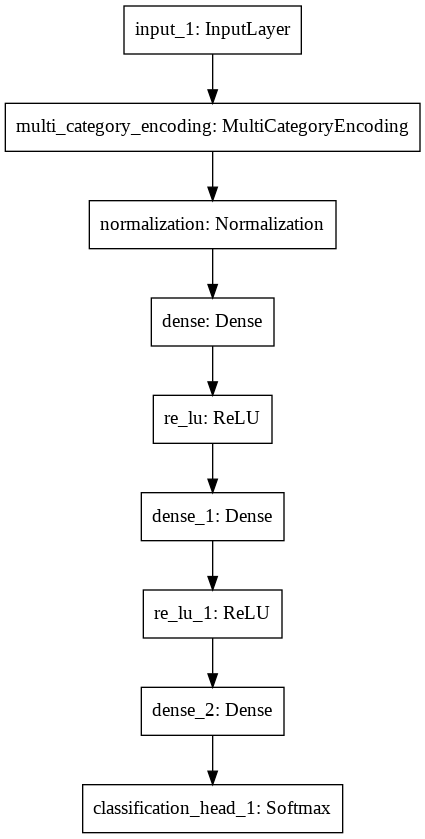

In [8]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='Images/AWGN_Model.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating Model

#### Training the Model

In [9]:
AWGN_Model.fit(X_Train, y_Train, epochs=50, batch_size=32, validation_split=0.1,shuffle=True)

Epoch 1/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2908 - accuracy: 0.8854 - val_loss: 0.3373 - val_accuracy: 1.0000
Epoch 2/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2221 - accuracy: 0.9057 - val_loss: 0.3141 - val_accuracy: 1.0000
Epoch 3/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2115 - accuracy: 0.9062 - val_loss: 0.3142 - val_accuracy: 1.0000
Epoch 4/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2075 - accuracy: 0.9066 - val_loss: 0.2998 - val_accuracy: 1.0000
Epoch 5/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2063 - accuracy: 0.9065 - val_loss: 0.3199 - val_accuracy: 1.0000
Epoch 6/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2055 - accuracy: 0.9065 - val_loss: 0.2924 - val_accuracy: 1.0000
Epoch 7/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2054 - accuracy: 0.9064 - val_loss: 0.2741 - val_accuracy: 1.0000
Epoch 

#### Evaluate the Model

Evaluating Model
938/938 [==============================] - 2s 2ms/step - loss: 1.7904 - accuracy: 0.7511
SNR: 5 Accuracy: 0.7511333227157593
938/938 [==============================] - 2s 2ms/step - loss: 1.0192 - accuracy: 0.8208
SNR: 10 Accuracy: 0.8208333253860474
938/938 [==============================] - 2s 2ms/step - loss: 0.4816 - accuracy: 0.8789
SNR: 15 Accuracy: 0.8788999915122986
938/938 [==============================] - 2s 2ms/step - loss: 0.2641 - accuracy: 0.9067
SNR: 20 Accuracy: 0.9066666960716248
938/938 [==============================] - 2s 2ms/step - loss: 0.2244 - accuracy: 0.9117
SNR: 25 Accuracy: 0.9116666913032532
938/938 [==============================] - 2s 2ms/step - loss: 0.2170 - accuracy: 0.9149
SNR: 30 Accuracy: 0.9148666858673096


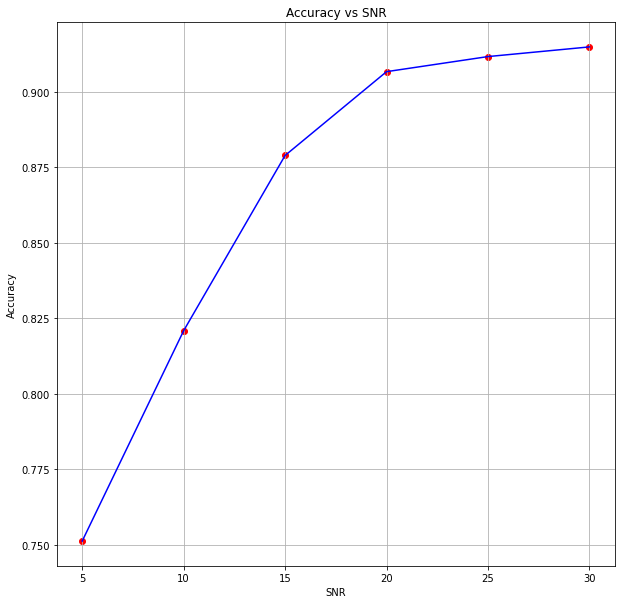

In [10]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "AWGN_Accuracy.jpg")

#### Save Model

In [11]:
AWGN_Model.save("Model/AWGN.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [12]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('Rayleigh',L=2)

#### Creating a CNN Classifier

In [13]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.3)

Trial 1 Complete [00h 00m 16s]
val_loss: 0.11849616467952728

Best val_loss So Far: 0.11849616467952728
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1085 - accuracy: 0.9769
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3147 - accuracy: 0.8675
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.2239 - accuracy: 0.9413
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.8871 - accuracy: 0.9248
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1001 - accuracy: 0.9685
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

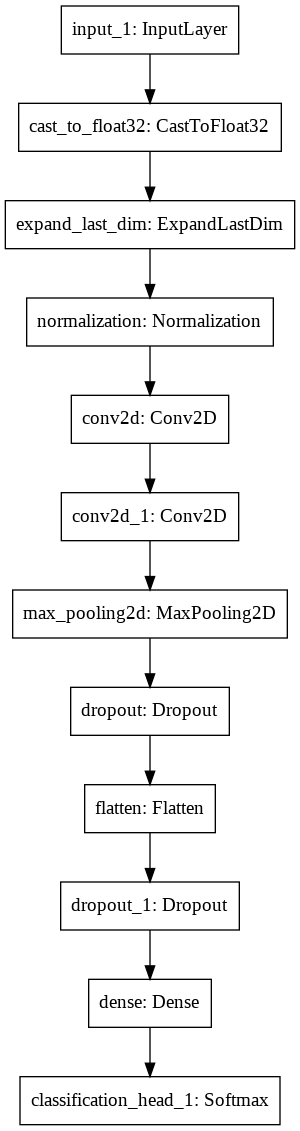

In [14]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='Images/Rayleigh_Model_L=2.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [15]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.1670 - accuracy: 0.9650 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 2/20
657/657 [==============================] - 2s 4ms/step - loss: 8.4203e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 3/20
657/657 [==============================] - 2s 4ms/step - loss: 1.9418e-04 - accuracy: 1.0000 - val_loss: 6.7732e-04 - val_accuracy: 1.0000
Epoch 4/20
657/657 [==============================] - 2s 4ms/step - loss: 3.2599e-05 - accuracy: 1.0000 - val_loss: 1.4871e-04 - val_accuracy: 1.0000
Epoch 5/20
657/657 [==============================] - 2s 4ms/step - loss: 9.9750e-06 - accuracy: 1.0000 - val_loss: 6.0170e-05 - val_accuracy: 1.0000
Epoch 6/20
657/657 [==============================] - 2s 4ms/step - loss: 5.3888e-06 - accuracy: 1.0000 - val_loss: 2.6325e-05 - val_accuracy: 1.0000
Epoch 7/20
657/657 [==============================] - 2s 4ms/step - loss: 2.8481e-06 - accuracy: 1.0000 - val_lo

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 5.7395e-08 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 2.6385e-09 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.2584e-10 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.0331e-10 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.9868e-10 - accuracy: 1.0000
SNR: 25 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.2716e-10 - accuracy: 1.0000
SNR: 30 Accuracy: 1.0


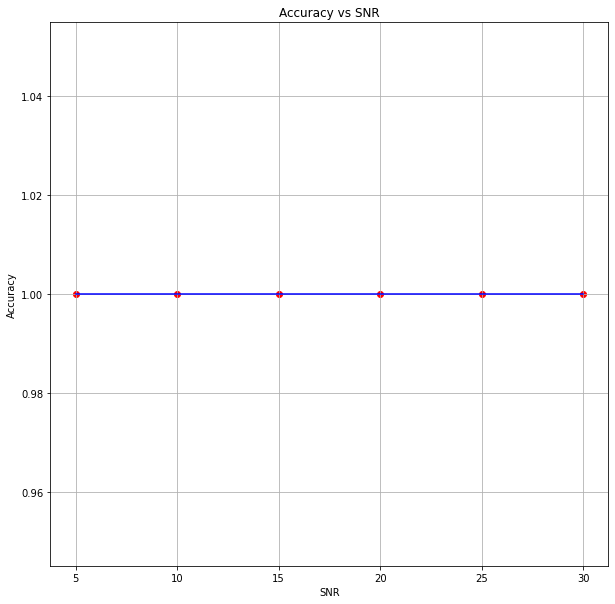

In [16]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "Rayleigh_Accuracy_L=2.jpg")

#### Save CNN Model

In [17]:
Rayleigh_Model.save("Model/Rayleigh_L=2.h5")

## AutoML Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [18]:
X_Train, y_Train, X_Valid, y_Valid = GenerateDatasets('Rayleigh',L=3)

#### Creating a CNN Classifier

In [19]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.3)

Trial 1 Complete [00h 00m 14s]
val_loss: 0.1409987360239029

Best val_loss So Far: 0.1409987360239029
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0913 - accuracy: 0.9736
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.8848 - accuracy: 0.9169
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.4379 - accuracy: 0.9280
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3910 - accuracy: 0.9111
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3136 - accuracy: 0.9426
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

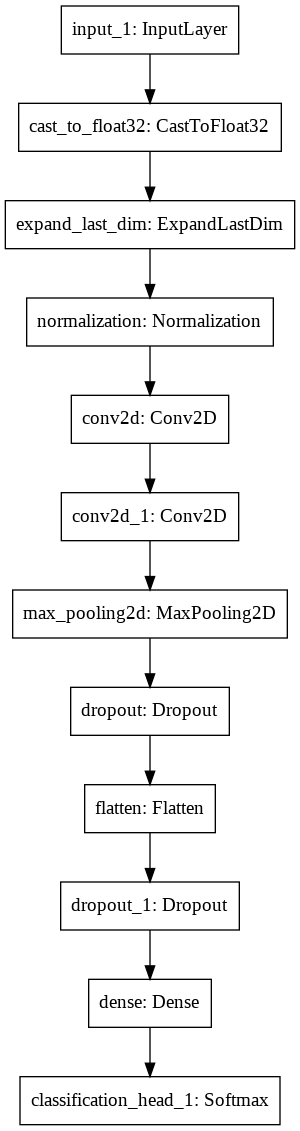

In [20]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='Images/Rayleigh_Model_L=3.png', show_shapes=False,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [21]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=20, batch_size=16, validation_split=0.3,shuffle=True)

Epoch 1/20
657/657 [==============================] - 3s 4ms/step - loss: 0.1795 - accuracy: 0.9681 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 2/20
657/657 [==============================] - 2s 4ms/step - loss: 5.3318e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/20
657/657 [==============================] - 2s 4ms/step - loss: 8.8514e-05 - accuracy: 1.0000 - val_loss: 3.9895e-04 - val_accuracy: 1.0000
Epoch 4/20
657/657 [==============================] - 3s 4ms/step - loss: 3.5372e-05 - accuracy: 1.0000 - val_loss: 1.4485e-04 - val_accuracy: 1.0000
Epoch 5/20
657/657 [==============================] - 2s 4ms/step - loss: 1.6374e-05 - accuracy: 1.0000 - val_loss: 7.3171e-05 - val_accuracy: 1.0000
Epoch 6/20
657/657 [==============================] - 2s 4ms/step - loss: 7.3211e-06 - accuracy: 1.0000 - val_loss: 3.4351e-05 - val_accuracy: 1.0000
Epoch 7/20
657/657 [==============================] - 2s 4ms/step - loss: 5.0201e-06 - accuracy: 1.0000 - val_lo

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 4.9734e-08 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.9212e-08 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.7503e-08 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.6589e-08 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.5834e-08 - accuracy: 1.0000
SNR: 25 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 3.5779e-08 - accuracy: 1.0000
SNR: 30 Accuracy: 1.0


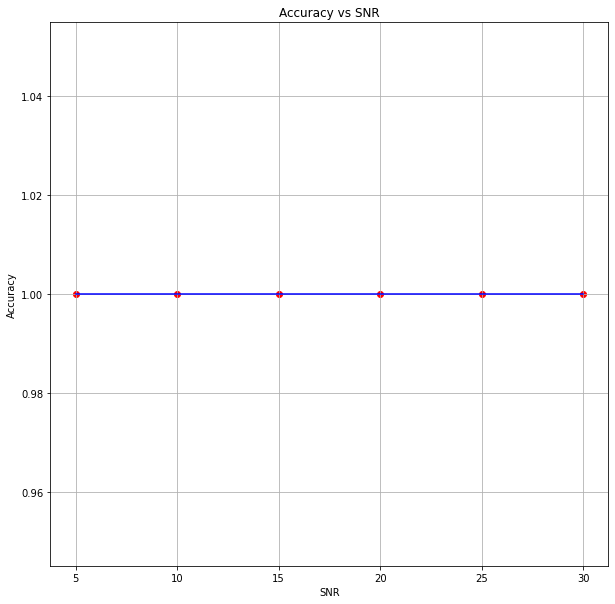

In [22]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "Rayleigh_Accuracy_L=3.jpg")

#### Save CNN Model

In [23]:
Rayleigh_Model.save("Model/Rayleigh_L=3.h5")